# Accès au données GEE et réaliser des ananlyses spatiales avec des données locales

Disposer des librairies python gee

In [ ]:
!pip install earthengine-api

Initialiser la connection avec l'API GEE

In [ ]:
import ee

## S'autentifier et autoriser l'API
- Cette opération nécessite d'avoir un compte Google et d'authoriser l'API à accéder à notre compte google
- Vous devrez alors vous connecter à votre compte Google à l'aide de vos identifiants de connexion.
- Une fois connecté, vous devrez donner l'autorisation d'accès à Google Earth Engine. Cliquez sur "Autoriser" pour permettre à l'API de Google Earth Engine d'accéder à vos données.
- Copiez le code d'authentification qui s'affiche sur la page Web et collez-le dans votre environnement Python pour finaliser l'opération d'authentification. Sur VScode c'est au milieu en haut de l'interface de l'application qu'une textBox s'affiche et dans l'aquelle il faut entrer le Token

In [ ]:
ee.Authenticate()

Une fois l'opération d'authentification terminée, vous pourrez accéder aux données de Google Earth Engine et effectuer des analyses à l'aide de Python.

Il est important de noter que l'opération d'authentification ne doit être effectuée qu'une seule fois, sauf si vous révoquez l'accès de l'API de Google Earth Engine à votre compte Google. Si vous rencontrez des problèmes avec l'authentification, assurez-vous que vous êtes connecté à votre compte Google et que vous avez donné l'autorisation d'accès à Google Earth Engine.

## Initialiser la connection

In [ ]:
ee.Initialize()

## Importer les librairies qui vont nous permettre d'effectuer nos traitements et de visualiser nos resultats pour nos essais

In [ ]:
import geemap.foliumap as geemap
import geemap as gee

import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
import rasterio
from rasterio.plot import show

In [ ]:
# ##### Define a method for displaying Earth Engine image tiles to folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  layer = folium.raster_layers.TileLayer(
      tiles = map_id_dict['tile_fetcher'].url_format,
      attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name = name,
      overlay = True,
      control = True
  )
  layer.add_to(self)
  return layer
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
def extract_pixel_value(img, region,bandName, scale):
  """Extract pixel value from an image for a given region"""
  value = img.reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=region,
      scale=scale,
      maxPixels=1e9
  ).get(bandName)
  return value

Définir une région de travail 

In [ ]:
region = ee.Geometry.Polygon(
  [[[163.514541939,-22.843300096],[168.154310608,-22.847855092],[168.106086735,-19.52950213],[163.570176236,-19.525048733],[163.514541939,-22.843300096]]])

In [ ]:
GT = ee.Geometry.Polygon(
  [[[1,-22],[1.1,-22.1],[168.106086735,-19.52950213],[163.570176236,-19.525048733],[163.514541939,-22.843300096]]])

In [ ]:
dumbea = ee.Geometry.Polygon([[[166.387779807,-22.2276038],[166.387779807,-22.039679148],[166.606135574,-22.039679148],[166.606135574,-22.2276038],[166.387779807,-22.2276038]]])

In [ ]:
gfcc = ee.ImageCollection('UMD/hansen/global_forest_change_2020').filterBounds(region)
gfc = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")

In [ ]:
gfc

In [ ]:
image = gfc.clip(dumbea)
image

Obtenir les informations sur l'image

In [ ]:
# information pour chaque bands de l'image
image.getInfo()

In [ ]:
# Sa projection

image.projection().getInfo()

In [ ]:
# Obtenir l'échelle de la projection

scale = image.projection().nominalScale().getInfo()
scale

In [ ]:
projection , transform = image.projection().getInfo()['crs'] , image.projection().getInfo()['transform']

In [ ]:
bands_list = image.getInfo()['bands']

Pour obtenir des informations sur la bandes

In [ ]:
band = bands_list[0]
band

In [ ]:
# Extraire les dimensions de l'image
width = band['dimensions'][0]
height = band['dimensions'][1]


Si on souhaite travailler sur une bande unique alors on indique quelle bande par son identifiant 

In [ ]:
treecover = image.select(band['id'])
treecover

# Extraire des informations / données de l'image

Pour vectoriser le raster on utilise reduceToVectors()

In [ ]:
reduction = treecover.reduceToVectors(
    geometry = None,
    crs = image.projection(),
    scale = scale,
    geometryType = 'polygon',
    eightConnected = True,
    labelProperty = 'zone',

    maxPixels = 1e15,
    tileScale = 16
)

Il y a des limites fixé à 5000 objets lors de la génération 

In [ ]:
# la génération des objets ne ce fait qu'à partir de cette commande
reduction.getInfo()

In [ ]:
# si le nombre de vecteurs générés est plus grand que 5000, on découpe la forme de base et on recommence la réduction.

reduction.size()

In [ ]:
reduction.limit(1).getInfo()

Afficher les 5000 objets sur une carte ici

In [ ]:
# instancier la carte
map = folium.Map(location=[-22.00, 166.00], zoom_start=8)
map

In [ ]:
#limiter le nombre d'objet et les ajouter à la carte
reduction.getInfo()
data = reduction.limit(500).getInfo()['features']
data
for feature in data:
    geom = feature['geometry']
    coords = geom['coordinates']
    if geom['type'] == 'Polygon' or geom['type'] == 'MultiPolygon':
        folium.GeoJson({
            'type': geom['type'],
            'coordinates': coords
        }).add_to(map)

In [ ]:
#afficher la carte
display(map)

## Obtenir des données uniquement à partir d'un seuil
Dans notre cas nous souhaitons le treecover correspondant à 30% et +
On applique donc un masque sur la donnée

In [ ]:
seuil = 30
# Créer un masque pour les valeurs de pixel inférieures au seuil
masque = gfc.gt(seuil)

# Appliquer le masque à l'image
image_filtree = gfc.updateMask(masque)



Nous souhaitons connaitre les valeurs distinct des classes d'objets présent dans l'image

In [ ]:
# donne les valeurs réduites
dic_valeur = ee.Dictionary(
    image_filtree.select(band['id']).reduceRegion(
    geometry= dumbea,
    reducer=ee.Reducer.toList(),
    scale=scale, 
    maxPixels=1e13))
dic_valeur


In [ ]:
ee.List(dic_valeur.get(band['id'])).distinct().getInfo()

## Extraire tous les pixels d'un zone

Attention il existe une limit dans la génération 
Too many pixels in sample; must be <= 262144.

In [ ]:
# nous devons extraire à partir d'un zone pour sampleRectangle
# exemple avec dumbéa, la zone est trop grande
i = gfc.select(band['id']).sampleRectangle(region=dumbea)
i.get(band['id']).getInfo()

Réduire la zone à une taille <= 262144

In [ ]:
small_geom = ee.Geometry.Polygon(
        [[[166.3890956644388, -22.07969187692815],
          [166.3890956644388, -22.178282082312165],
          [166.45913350623567, -22.178282082312165],
          [166.45913350623567, -22.07969187692815]]]);

In [ ]:
i = gfc.select(band['id']).sampleRectangle(region=small_geom)

On peut maintenant convertir en Numpy Array

In [ ]:
np.array(i.get(band['id']).getInfo())

## Télécharger l'image via drive

In [ ]:
task = ee.batch.Export.image.toDrive(
  image=gfc,
  description='image_gfc',
  folder='gfc_folder',
  fileNamePrefix=f"gfc_image_{dumbea}",
  region=dumbea,
  scale=scale)

task.start()

In [ ]:
task.status()

Palette de couleur pour la visualisation dans folium

In [ ]:
viz_1b_param = {'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']}
treecover2000_viz_params = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'gamma': [0.95]
}
loss_viz_params = {
    'bands': ['loss'],
    'min': 0,
    'max': 1,
    'gamma': [0.95]
}
lossyear_viz_params = {
    'bands': ['lossyear'],
    'min': 0,
    'max': 21,
    'gamma': [0.95]
}


In [ ]:
url = image.getDownloadURL({
    'scale': 100,
    'crs': 'EPSG:4326'
})

In [ ]:
response = requests.get(url)
response

In [ ]:
ee.Image(gfc).getMapId(lossyear_viz_params)

In [ ]:
masked_image = gfc.mask(gfc)

# Obtenir des statistiques des données Raster sur GEE à partir des géometries vectorielles locales


 (sans téléchargement ou convertion des données) 
 Exemple avec l'utilisation d'une image landsat
 - Création de plusieurs rectangles (BBOX), ayant un attribut "name"
 - Récupération des statistiques (valeurs moyennes des pixels dans la zone) grace à reduceRegions et son parametre reducer
 

In [ ]:
imageLandsat = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Créer une collection de zones géographiques
polygons = ee.FeatureCollection([
  ee.Feature(ee.Geometry.Rectangle([-122.6, 37.4, -122.3, 37.8]), {'name': 'zone 1'}),
  ee.Feature(ee.Geometry.Rectangle([-122.5, 37.3, -122.2, 37.7]), {'name': 'zone 2'})
])
print(polygons.getInfo())

# Agréger les valeurs de pixels sur les zones géographiques
stats = imageLandsat.reduceRegions(
  collection=polygons,
  reducer=ee.Reducer.mean(),
  scale=30
)

# Afficher les statistiques
stats.getInfo()

Regardons sur une carte les superpositions des objets Image et Feature

In [ ]:
image = imageLandsat
# lister les noms des bandes de l'image pour faire une représentation visuelle sur une carte de l'image
bands = image.bandNames()
bands.getInfo()

features_geom = polygons

bandList = bands.getInfo()[1:3]

# emprise de la carte
coords =  features_geom.geometry().bounds().getInfo()['coordinates'][0]

# palette de couleurs pour les bandes 2,3,4
palette = {
    'bands': bandList,
    'min': 0.0,
    'max': 0.3,
    'gamma': [0.95]
}

# initialisation de la carte avec ajout des layers
map = folium.Map(location=[-22.00, 166.00], zoom_start=8)
map.add_ee_layer(image, palette,'Test')
map.add_child(folium.GeoJson(data=features_geom.getInfo()))
map.fit_bounds(bounds=[[coords[0][1], coords[0][0]], [coords[2][1], coords[2][0]]])
# Affichage
display(map)

Même chose mais avec des données réelle sur la NC

In [ ]:
# scale = image.projection().nominalScale().getInfo()

Poly = ee.FeatureCollection([
  ee.Feature(ee.Geometry.Polygon(
    [[[164.984719986043, -21.1539246685163],
       [164.984880495297, -21.1539547962526], 
       [164.984865381124, -21.154025653579], 
       [164.984704871796, -21.1539955258281], 
       [164.984719986043, -21.1539246685163]]]
    ),{"id": "565", "commune": "POUEMBOUT", "province": "NORD"})])

features_geom = Poly
image = gfc


# Agréger les valeurs de pixels sur la zone géographique. On clip l'image sur une emprise réduite
min = image.reduceRegions(
  collection=features_geom,
  reducer=ee.Reducer.min(),
)

max = image.reduceRegions(
  collection=features_geom,
  reducer=ee.Reducer.max(),
)
mean = image.reduceRegions(
  collection=features_geom,
  reducer=ee.Reducer.mean(),
)


In [ ]:

# Afficher les statistiques
mean.getInfo()


In [ ]:
max.getInfo()

In [ ]:
polygons.size().getInfo()

Regardons avec une représentation cartographique

In [ ]:
image = gfc

# lister les noms des bandes de l'image pour faire une représentation visuelle sur une carte de l'image
bands = image.bandNames()
bands.getInfo()

features_geom = Poly
bandList = bands.getInfo()[0]

# emprise de la carte
coords =  features_geom.geometry().bounds().getInfo()['coordinates'][0]

# palette de couleurs pour les bandes 2,3,4
palette = {
    'bands': bandList,
    'min': 0.0,
    'max': 100.0,
    'gamma': [0.95]
}

# initialisation de la carte avec ajout des layers
map = folium.Map(location=[-22.00, 166.00], zoom_start=8)
map.add_ee_layer(image, palette,'Test')
map.add_child(folium.GeoJson(data=features_geom.getInfo()))
map.fit_bounds(bounds=[[coords[0][1], coords[0][0]], [coords[2][1], coords[2][0]]])

display(map)

Il se peut que la zone géometrique soient en dehord de l'image. Dans ce cas vous obtiendrez des valeurs statisique moyenne = NONE

Il se peut aussi selon le reducer utilisé que vous ayez des valeurs NONE. Cela est du au fait que votre géométrie ne contient aucun centroid de pixel (pour toutes les methodes statistique sauf mean()), ou qu  si vous utilisz mean() seulment <50% de pixel est dans la région.

Pixels are determined to be in the region (and weighted) according to the following rules, applied in the specified scale and projection:

    Unweighted reducers (e.g. ee.Reducer.count() or ee.Reducer.mean().unweighted()): pixels are included if their centroid is in the region and the image's mask is non-zero.
    Weighted reducers (e.g. ee.Reducer.mean()): pixels are included if at least (approximately) 0.5% of the pixel is in the region and the image's mask is non-zero; their weight is the minimum of the image's mask and the (approximate) fraction of the pixel covered by the region.



Dans notre cas, la géométrie est petite et seule la moyenne peut revoyer des valeurs. Si nous souhaitons compter le nombre de pixel nous obtenons la valeur 0

In [ ]:
stats = image.reduceRegions(
  collection=features_geom,
  reducer=ee.Reducer.count(),
)

# Afficher les statistiques
stats.getInfo()

### Limitations
le nombre maximum de pixel dans la région est atteint (1 0000 000 autorisés)

The maxPixels parameter is needed to get the computation to succeed. If this parameter is left out of the example, an error is returned, which looks something like:
Dictionary (Error)
  Image.reduceRegion: Too many pixels in the region. Found 527001545, but only 10000000 allowed.

# Calcul en condition quasi réelle en partant de données issues d'un service geojson du gouvernement de NC

Afin de se rapprocher du UC de nos traitements actuelle nous devons commencer le processus à partir d'un Geodataframe. ce type de format est fournis par notre catalogue Intake. 

In [ ]:
import geopandas as gpd
# Charger un GeoDataFrame de points représentant les villes de France
gdf = gpd.read_file('https://opendata.arcgis.com/api/v3/datasets/b5a303d89f2f407e8c194983c86418a7_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1')
print(gdf.shape)


In [ ]:
gdf.crs

Pour les tests, nous n'exploiterons qu'un échantillons de 10 objet pour l'instant. A savoir que lors de nos traitements, nous effectuons des chuncks pouvant correspondre à ce nombre d'objet.

In [ ]:
from datetime import datetime

def convert_datetime_columns(gdf):
    """Convertit toutes les colonnes de type 'datetime64[ns]' ou 'timestamp' en chaînes de caractères au format 'YYYY-MM-DD HH:MM:SS'.
    
    Args:
        gdf (geopandas.GeoDataFrame): Le GeoDataFrame contenant les colonnes de date à convertir.
    
    Returns:
        geopandas.GeoDataFrame: Le GeoDataFrame avec les colonnes de date converties en chaînes de caractères.
    """
    # Obtient une liste de toutes les colonnes de type 'datetime64[ns]' ou 'timestamp'
    datetime_cols = gdf.select_dtypes(include=['datetime64[ns]','datetime64[ns, UTC]']).columns.tolist()
    
    # Convertit chaque colonne de date en chaînes de caractères
    for col in datetime_cols:
        gdf[col] = gdf[col].apply(lambda x: datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
    
    return gdf

Echantillon de 10 objet pour nos tests

In [ ]:
gdf = gdf.sample(10)
gdf.dtypes

gdf = convert_datetime_columns(gdf)

Nous devons convertir le geodataframe en objet featureCollection de GEE. Pour cela nous devons "repasser" les objets en geoJson, afin d'etre directement traduit dans l'objet GEE.

In [ ]:
# Convertir GeoJSON en FeatureCollection GEE
fc = ee.FeatureCollection(gdf.__geo_interface__)
fc

Possible defaire la convertion avec geemap

In [ ]:
fc = geemap.geopandas_to_ee(gdf)

Afficher les données sur une carte

In [ ]:
image = gfc
bands = image.bandNames()
bands.getInfo()

bandList = bands.getInfo()[0]

features_geom = fc


coords =  features_geom.geometry().bounds().getInfo()['coordinates'][0]
# palette de couleurs pour les bandes 2,3,4
palette = {
    'bands': bandList,
    'min': 0.0,
    'max': 100.0,
    'gamma': [0.95]
}

# initialisation de la carte avec ajout des layers
map = folium.Map(location=[-22.00, 166.00], zoom_start=8)
map.add_ee_layer(image, palette,'Test')
map.add_child(folium.GeoJson(data=features_geom.getInfo()))
map.fit_bounds(bounds=[[coords[0][1], coords[0][0]], [coords[2][1], coords[2][0]]])

display(map)

# Calculer les statistiques

## Full Cloud : A partir des Feature collection sur GEE

On peut combiner plusieurs réducteurs afin d'éviter de traiter chaque agrégateur indépendamment.

In [ ]:
scale = image.projection().nominalScale().getInfo()
features_geom = fc

# Définissez l'agrégateur à utiliser
reducer = ee.Reducer.min().combine(ee.Reducer.max(), sharedInputs=True)
bands = ['treecover2000', 'loss', 'gain']
# Appliquez l'agrégateur à chaque bande pour la FeatureCollection
result = image.reduceRegions(
  reducer = reducer,
  collection = features_geom,
)



In [ ]:
result

A la fin des calculs statistiques, il faut reconvertir les objets pour pouvoir les importer ensuite en base. 

In [ ]:
from shapely.geometry import shape
features = result.getInfo()['features']

# Transformer la liste des entités géographiques en une liste de dictionnaires
data = []
for feature in features:
    properties = feature['properties']
    geometry = shape(feature['geometry'])
    data.append(dict(properties, geometry=geometry))

# Créer une série GeoPandas à partir de la liste de dictionnaires
gdf = gpd.GeoDataFrame(data)
gdf.set_crs(image.projection().getInfo()['crs'])
gdf.shape
gdf

Les temps de conversion  FC -> GDF sont assez long : 10 objets 50 sec

In [ ]:
seuil = 30
# Créer un masque pour les valeurs de pixel inférieures au seuil
masque = gfc.gt(seuil)

# Appliquer le masque à l'image
image_filtree = gfc.updateMask(masque)
# Agréger les valeurs de pixels sur les zones géographiques
stats = image_filtree.reduceRegions(
  collection=Poly,
  reducer=ee.Reducer.mean(),
  scale=30
)

##  Localement sans l'API GEE (Numpy / rasterstat)

On télécharge des emprises de raster de petite taille, correspondant à l'emprise des données qui sous interesse et on calcul les statistiques complete avec la librairie Rasterstat.

Cela nécessite de disposer d'un raster pour chaque géométrie (ou pour  un groupe de données proche spatialement), donc de convertir l'image GEE en numpy Array afin d'etre exploitable avec rasterio et ensuite traiter le raster avec rasterstat

C'est déjà cette méthode qui est employée aujourd'hui. il faut pour cela tester si le nombre de flux et d'interrogation à GEE ne seraient pas limités.

In [ ]:
#samplegdf = gdf.sample(1)

#samplegdf = gdf[(gdf['objectid']==1864)]
samplegdf = gdf[(gdf['objectid']==1574)]
#samplegdf = gdf[(gdf['objectid']==1715)]

fc = gee.geopandas_to_ee(samplegdf)


i = gfc.select(band['id']).sampleRectangle(region=fc)
i

In [ ]:
fc_ = geemap.ee_to_geopandas(ee.FeatureCollection([i]))


In [ ]:
i.getInfo()

In [ ]:
bbox = fc_.total_bounds
xmin, ymin, xmax, ymax = fc_.total_bounds
xmin, ymin, xmax, ymax

In [ ]:
raster = np.array(i.get(band['id']).getInfo())
raster

Cas particuliers avec les arrays ne correspondant pas à un shape sur 2 dimensions et plus d'une cellule.

Nous avons besoin de definir la fonction Affine permettant de possitionner le tableau dans l'espace selon la projection initiale de l'image

In [ ]:
# Définir les coordonnées du bounding box
xmin, ymin, xmax, ymax = fc_.total_bounds

# Définir les dimensions de l'image en pixels
img_width, img_height = (raster.shape[1],raster.shape[0])

# Calculer la résolution de l'image en pixels/mètre
res_x = (xmax - xmin) / img_width
res_y = (ymax - ymin) / img_height


# Créer un objet transform à partir de la matrice affine
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, img_width, img_height)
transform

In [ ]:
transform.a, transform.b, transform.c, transform.d, transform.e, transform.f

In [ ]:
affine_tuple = (transform.a, transform.b, transform.c, transform.d, transform.e, transform.f)
r = geemap.numpy_to_ee(raster, crs='EPSG:4326',transform=affine_tuple)

 Attention inversion / mirroir de l'image dû à une mauvaise conversion transform -> affine_tuple ou un bug de numpy_to_ee

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)
Map.addLayer(gfc, {}, 'gfc name')
Map.addLayer(r, {}, 'raster')
Map.addLayer(i, {}, 'Layer name')
Map.centerObject(i, zoom=18)
Map

Pas d'inversion si on utilise transform de rasterio et affichage avec matplotlib

Attention au cas où le nombre de pixel = 1. Le numpy array ne peut pas être dessiné par matplotlib.

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

fc_.plot(ax=ax, color='red', alpha=0.5)
show(raster, ax=ax, transform=transform, cmap='gray')

plt.show()

On observe un problème majeur dans la conversion du Numpy en image. SampleRectangle ne renvois pas l'affine de l'image et nous devons donc la recalculer sur la base de la bbox mais les pixels peripherique ne sont pas forcement aligné à la bbox, donc nous avons des décalages entre les objets. 

## Extraire un clip image et non un sampleRectangle pour calculer les statistiques

In [ ]:
samplegdf = gdf[(gdf['objectid']==1574)]
fc = geemap.geopandas_to_ee(samplegdf)


i = gfc.select(band['id']).clip(fc)
i

In [ ]:
transform_from_im= i.select(band['id']).projection().getInfo()['transform']
transform_from_im

In [ ]:
samplegdf

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)
Map.addLayer(i, {}, 'Layer name')
Map.addLayer(fc, {}, 'feature')
Map.centerObject(fc, zoom=18)
Map

In [ ]:
cliped = gee.ee_to_numpy(i, region=fc, default_value=255)

In [ ]:
cliped.shape

In [ ]:
cliped

Pour la suite il faut s'assurer que le numpy array soit bien en 2D.

In [ ]:
cliped = cliped.reshape(cliped.shape[0], (cliped.shape[1]*cliped.shape[2]))

In [ ]:
raster = cliped
# Définir les coordonnées du bounding box
xmin, ymin, xmax, ymax = samplegdf.total_bounds

# Définir les dimensions de l'image en pixels
img_width, img_height = (raster.shape[1],raster.shape[0])

# Calculer la résolution de l'image en pixels/mètre
res_x = (xmax - xmin) / img_width
res_y = (ymax - ymin) / img_height


# Créer un objet transform à partir de la matrice affine
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, img_width, img_height)
transform

In [ ]:
fig, ax = plt.subplots(figsize=(50, 12))

samplegdf.plot(ax=ax, edgecolor='blue', alpha=0.5)
show(cliped, ax=ax, transform=transform)

plt.show()

On perçoit que certains pixels ne sont pas "repris" sur certaine partie de la peripherie du polygon. se peut être lié à 2 chose : 

Les pixels ne sont pas pris si le perimètre ne passe pas en le centroïde de pixel mais sur la partie nord ils sont pourtant repris alors que le perimètre ne passe pas en leurs centroïdes.
Il y a donc probablement aussi mais à verifier un leger décalage dû aux projections/reprojections/echelle. 

lorsqu'on regarde dans GEE, on vois un décalage d'un pixel sur la pointe haute de l'objet 

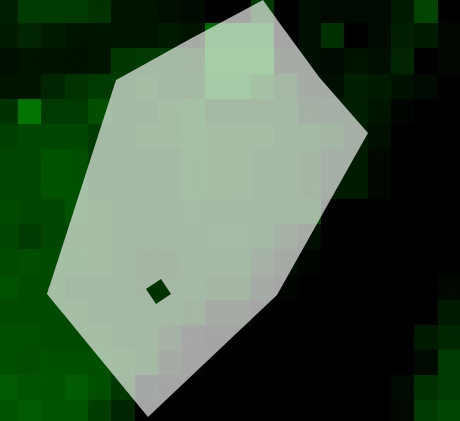 
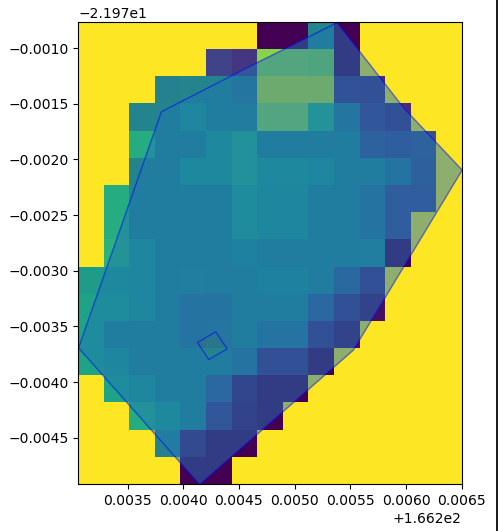

In [ ]:
affine_tuple = (transform.a, transform.b, transform.c, transform.d, transform.e, transform.f)
r = geemap.numpy_to_ee(cliped, crs='EPSG:4326',transform=affine_tuple)

r

Encore une fois, attention le numpy transformé en GEE est en mirroir. Problème lié au transform. A ce stade ce n'est pas grave, mais cela montre qu'il y a un effort à faire si on souhaite traduire d'un Numpy en EE.

In [ ]:
fc = geemap.geopandas_to_ee(samplegdf)

Map = geemap.Map(center=[40,-100], zoom=4)
Map.addLayer(gfc,{}, 'gfc')
Map.addLayer(r,{}, 'r')
Map.addLayer(i,{}, 'i')
Map.addLayer(fc,{}, 'fc')

Map.centerObject(fc, zoom=18)
Map

In [ ]:
fc.getInfo()

In [ ]:
!pip install rasterstats

In [ ]:
import rasterstats as rs

gdf= samplegdf
raster = cliped

rs.zonal_stats(gdf, raster, stats=['min', 'max', 'mean', 'median', 'std'], affine=transform, nodata=99,geojson_out=True,raster_out=True, all_touched=True)

In [ ]:
transform

In [ ]:
band['id']

### Optimisation avec fenetrage sur grille H3

In [ ]:
import h3

# Définir la résolution H3 souhaitée
resolution_h3 = 5

# Convertir les géométries du GeoDataFrame en hexagones H3
gdf['hexagone_h3'] = gdf.geometry.apply(lambda x: h3.geo_to_h3(x.centroid.y, x.centroid.x, resolution_h3))

# Grouper le GeoDataFrame par hexagone H3 et créer un GeoDataFrame d'emprises spatiales régulières
emprises_spatiales = gdf.groupby('hexagone_h3')['geometry'].apply(lambda x: gpd.GeoSeries(x.tolist())).reset_index().rename(columns={'level_1':'dummy'})
emprises_spatiales = emprises_spatiales[~emprises_spatiales['hexagone_h3'].duplicated()]
emprises_spatiales